 
 
 
 
 # Using machine learning to cluster and predict locations from Sony Lifelog API

In this notebook we will show how to apply machine learning to location data retrieved from the Sony Lifelog API, for finding important places in your life, and trying to predict movement between these locations. We will use clustering and classification methods from scikit-learn, a Python machine learning package. We assume you have already downloaded location data from the Lifelog API and saved it to a file called locations.json. For a short introduction, please see the Sony Developer World blog post here: http://developer.sonymobile.com/2015/07/28/app-developers-can-now-explore-lifelog-user-predictability-with-data-science-and-machine-learning/

## Load and extract the data

Load the location data retrieved from the Sony Lifelog API, and save it to a file 'locations.json'. For details on how to access the Sony Lifelog API, please see the Sony Developer World blog post here:

In [1]:
import json
file = open('locations.json')
j = json.load(file)[::-1] #the data is in reverse time order

The data has a number of attributes in a dictionary data structure, of which we will use position and time in this tutorial. Let's have a look.

In [2]:
len(j)

6939

In [3]:
j[3]

{u'accuracy': 57.64,
 u'altitude': 0.0,
 u'endTime': u'2014-06-03T12:00:04.534+02:00',
 u'id': u'829fd904-46e2-4683-bff2-e9a88b4a33b0',
 u'position': {u'latitude': 55.71815317808789,
  u'longitude': 13.226456038546642},
 u'sources': [{u'id': u'6abedd62f509feff',
   u'name': u'Lifelog',
   u'type': u'phone'}],
 u'startTime': u'2014-06-03T11:56:49.522+02:00'}

In [4]:
j[len(j)-1]

{u'accuracy': 21.814,
 u'altitude': 0.0,
 u'endTime': u'2015-01-08T10:27:54.631+01:00',
 u'id': u'b61387e3-e69a-47aa-ae67-8bb93be46c7f-2015-01-08',
 u'position': {u'latitude': 55.801516219115946,
  u'longitude': 12.973692059870128},
 u'sources': [{u'id': u'afb61515414d0db8',
   u'name': u'Lifelog',
   u'type': u'phone'}],
 u'startTime': u'2015-01-08T10:25:53.544+01:00'}

Extract the latitude and longitude data.     

In [5]:
lats = map(lambda loc: loc['position']['latitude'],j)
lons = map(lambda loc: loc['position']['longitude'],j)
locs = zip(lats, lons)

## Explore the data

Let's plot the data in a simple line plot just to get an initial view.

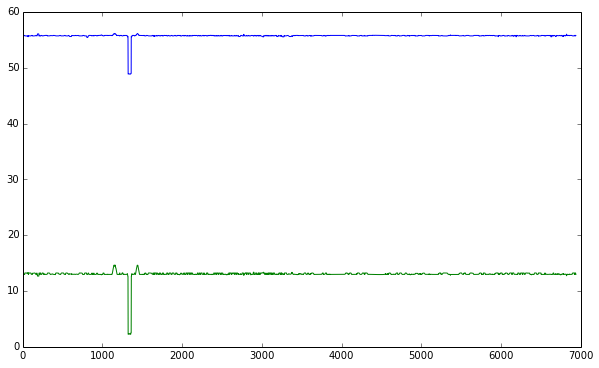

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(locs);

At this scale there seems to be little variation in both longitude and latitude data, except at a specific spike when there is a major change, which would indicate travel to a distant place, during which no location data is given. Let's plot it in a 2d plot:

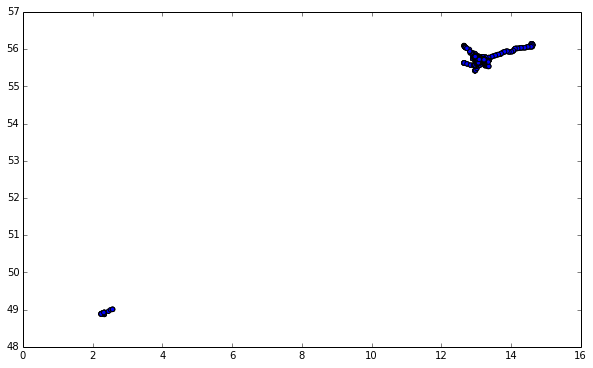

In [7]:
plt.scatter(lons, lats);

As we expect there is spatial structure in the data, and on set of point very far from the other. To understand how far, let's plot it on a map, centered on the majority of the point we saw in the line plot above:

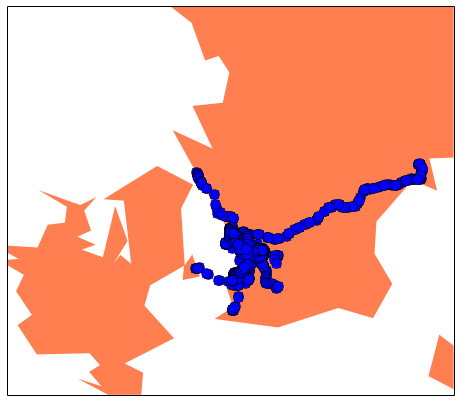

In [8]:
import mpl_toolkits.basemap as bm
fig = plt.figure(figsize=(8,8), dpi=100)
bmap = bm.Basemap(projection='merc', lat_0=55.7, lon_0=13.0,resolution = 'l', area_thresh = 0.1,llcrnrlon=11.0, llcrnrlat=55.0,urcrnrlon=14.9, urcrnrlat=56.9)
bmap.fillcontinents(color='coral')
x,y = bmap(lons, lats)
bmap.plot(x, y, 'bo', markersize=10)
plt.show()

This is obviously the south of Sweden. What about the distant spike of points?

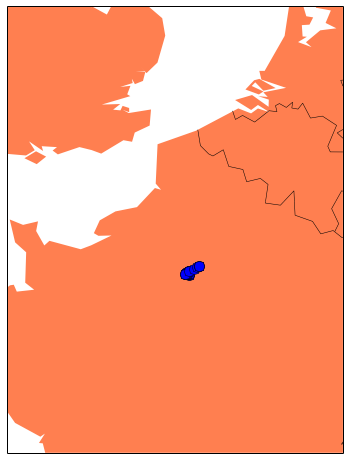

In [9]:
fig = plt.figure(figsize=(8,8), dpi=100)
bmap = bm.Basemap(projection='merc', lat_0=48.9, lon_0=2.25,resolution = 'l', area_thresh = 0.1,llcrnrlon=-2.0, llcrnrlat=46.0,urcrnrlon=6.0, urcrnrlat=52.9)
bmap.drawcountries()
bmap.fillcontinents(color='coral')
x,y = bmap(lons, lats)
bmap.plot(x, y, 'bo', markersize=10)
plt.show()

And this is clearly Paris, France.

## Finding personal points of interest through location clustering

We want to find clusters of location points that signify places that are important to the user, personal points of interest (POI). Use DBSCAN density based clustering to find clusters. DBSCAN has the advantage over centroid-based methods, e.g. K-means clustering, that we don't need to specify the number of clusters we are looking for, and that all points are not assigned to a cluster. This makes sense when trying find important places that the user makes transitions between, since we are not interested in assigning the transition points to any cluster.

Epsilon determines the size of the neighbourhood we count points in.

In [10]:
from sklearn import cluster
dbscan = cluster.DBSCAN(eps=0.002)

Fit model and each position to a cluster (or noise).

In [11]:
import numpy as np
np.set_printoptions(precision=3, suppress = True, edgeitems =10)

f = dbscan.fit_predict(np.array(locs))

How many cluster did we get for this value of epsilon? Let's have a the cluster labels.

In [12]:
print(set(f))

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, -1])


We got 74 clusters. -1 is the label for noise, and is not a cluster. Many clusters. How many visits to each of them?

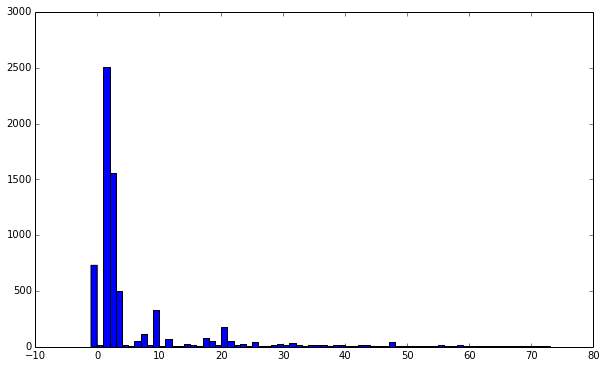

In [13]:
plt.hist(f, bins=74);

74 clusters seems to be a bit much if we want to find the most important POIs. Let's require at least 100 points within epsilon.

In [14]:
dbscan = cluster.DBSCAN(eps=0.002, min_samples=100)
f = dbscan.fit_predict(np.array(locs))
set(f)

{-1, 0, 1, 2, 3, 4, 5, 6}

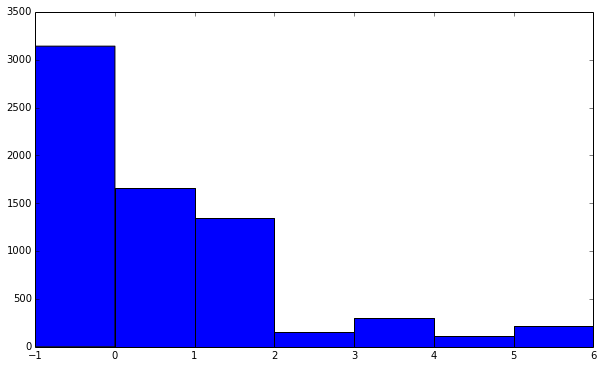

In [15]:
plt.hist(f, bins=7);

Lets plot the clusters with different colors

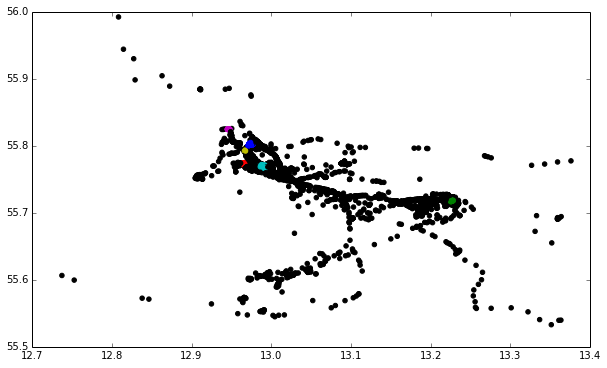

In [16]:
clrs = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
labels = dbscan.labels_.astype(np.int)
plt.scatter(lons, lats, color=clrs[labels].tolist())
plt.xlim(12.7,13.4)
plt.ylim(55.5,56.0);

Zoom in on the ones to the left.

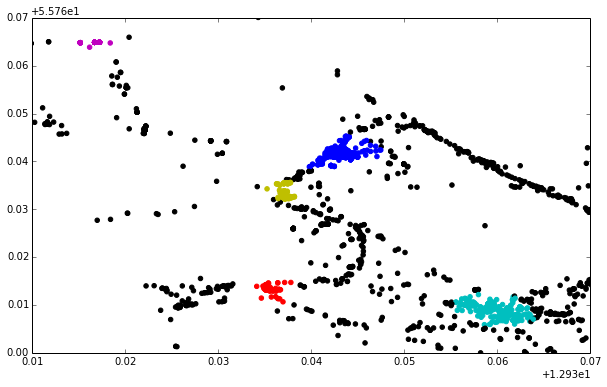

In [17]:
plt.scatter(lons, lats, color=clrs[labels].tolist())
plt.xlim(12.94,13.0)
plt.ylim(55.76,55.83);

And have a look at the one to the right as well.

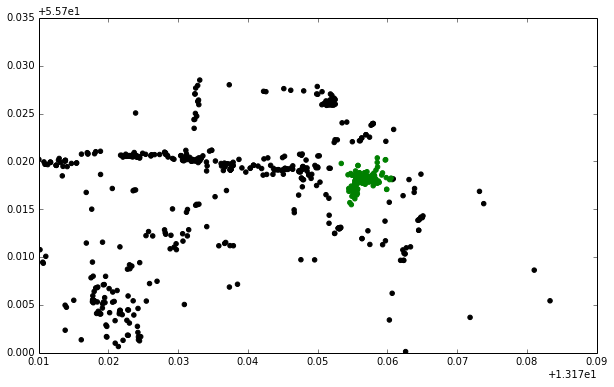

In [18]:
plt.scatter(lons, lats, color=clrs[labels].tolist())
plt.xlim(13.18,13.26)
plt.ylim(55.7,55.735);

Labels is now a list of locations, labeled with the id of the cluster it belongs to.

In [19]:
pois = labels.tolist()
print pois[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, -1, -1]


## Predict next point of interest

Let's try to predict which cluster (POI) you will move to next. Start by removing noise (-1, points not belonging to a cluster) and duplicates, since we are only intrested in transitions.

In [20]:
pois = filter(lambda x: x > -1,pois)

Remove repeating POIs

In [21]:
sequence=[pois[0]]
for i in range(len(pois)):
    if (pois[i]!=sequence[-1]):
        sequence.append(pois[i])

In [22]:
print sequence

[1, 2, 0, 2, 1, 0, 1, 0, 2, 0, 5, 0, 2, 5, 0, 1, 2, 6, 0, 1, 3, 2, 6, 0, 5, 0, 2, 1, 6, 0, 5, 2, 1, 3, 0, 5, 2, 1, 0, 5, 0, 6, 3, 6, 3, 5, 0, 6, 3, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 3, 0, 2, 0, 3, 0, 3, 0, 5, 1, 0, 1, 3, 0, 3, 0, 1, 0, 5, 0, 3, 0, 3, 5, 0, 1, 0, 1, 0, 1, 2, 0, 2, 1, 3, 0, 3, 1, 2, 0, 3, 0, 5, 2, 1, 5, 0, 3, 0, 6, 0, 1, 2, 0, 2, 1, 5, 0, 1, 3, 0, 1, 0, 3, 0, 5, 2, 0, 2, 0, 5, 0, 3, 6, 0, 1, 2, 0, 5, 0, 2, 3, 0, 2, 1, 2, 0, 1, 2, 5, 0, 1, 2, 5, 0, 3, 1, 0, 2, 3, 0, 2, 5, 0, 5, 0, 6, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 2, 5, 0, 3, 5, 0, 2, 1, 0, 3, 0, 3, 0, 3, 0, 5, 0, 6, 0, 1, 0, 5, 2, 1, 3, 0, 1, 3, 5, 0, 1, 2, 0, 3, 0, 1, 2, 0, 2, 5, 0, 5, 0, 6, 3, 0, 2, 1, 0, 1, 2, 5, 0, 2, 1, 0, 1, 2, 5, 0, 2, 1, 3, 0, 6, 5, 0, 5, 0, 2, 1, 3, 2, 0, 3, 1, 2, 0, 5, 0, 2, 1, 3, 0, 1, 0, 2, 0, 5, 0, 3, 0, 3, 0, 1, 2, 0, 2, 1, 0, 1, 2, 0, 5, 0, 1, 2, 0, 5, 0, 3, 0, 5, 0, 2, 1, 0, 5, 2, 1, 3, 2, 5, 0, 1, 5, 0, 5, 2, 1, 2, 0, 3, 0, 2, 3, 6, 0, 1, 0, 1, 0, 1, 3, 5, 0, 2, 1, 5, 0, 3, 5, 0, 5, 0, 

This sequence can be seen as a graph. Let's visualize it using the networkx package.

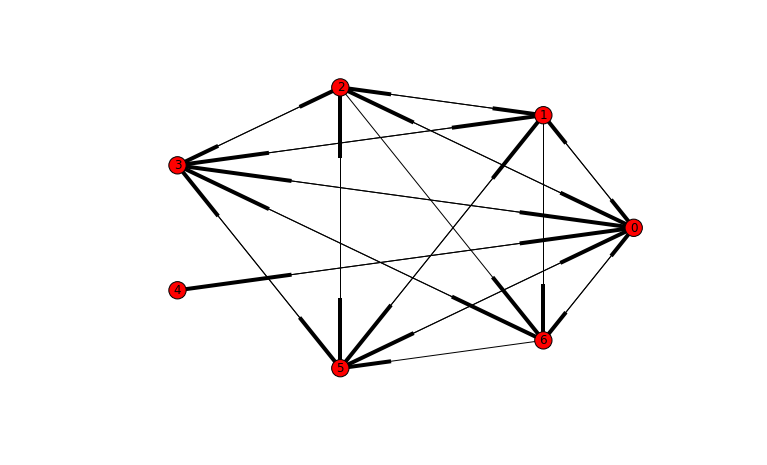

In [23]:
import networkx as nx
G=nx.DiGraph()
for i in range(len(sequence)-1):
    if G.has_edge(sequence[i], sequence[i+1]):
        G[sequence[i]][sequence[i+1]]['weight'] += 1
    else:
        G.add_edge(sequence[i], sequence[i+1], weight=1)
nx.draw_shell(G)

We can see that most edges are reciprocal, except for two edges that are one-directional. Also, one node is only visited from one specific node, and no others.

How many visits to the POIs after removing repeats?

(array([193,  96,  94, 103,   1,  96,  29]),
 array([ 0.   ,  0.857,  1.714,  2.571,  3.429,  4.286,  5.143,  6.   ]))

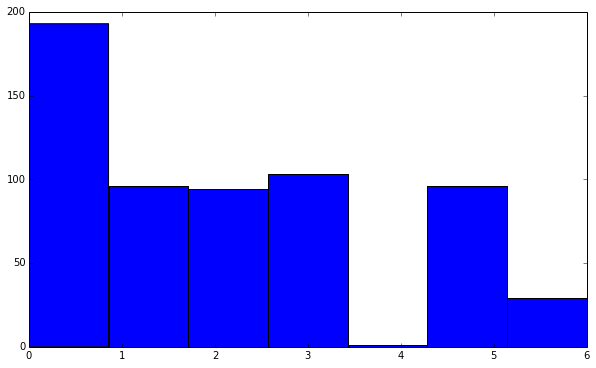

In [24]:
plt.hist(sequence, bins=7);
np.histogram(sequence, bins=7)

One of them has significantly fewer visits after removing repeating clusters. Why? This means it was frequently visited, but that  all of the visits came in a straight sequence with no visits to other clusters (but it could be interrupted by -1, noise). This should be investigated further, but I leave it as an exercise to the reader.

Now we want to predict the next POI given the current one. Create a training set of transitions:

In [25]:
currentPOI = np.vstack(sequence[0:(len(sequence)-1)])
nextPOI = np.array(sequence[1:(len(sequence))])
zip(currentPOI, nextPOI)[0:20]

[(array([1]), 2),
 (array([2]), 0),
 (array([0]), 2),
 (array([2]), 1),
 (array([1]), 0),
 (array([0]), 1),
 (array([1]), 0),
 (array([0]), 2),
 (array([2]), 0),
 (array([0]), 5),
 (array([5]), 0),
 (array([0]), 2),
 (array([2]), 5),
 (array([5]), 0),
 (array([0]), 1),
 (array([1]), 2),
 (array([2]), 6),
 (array([6]), 0),
 (array([0]), 1),
 (array([1]), 3)]

Throw a couple of different machine learning models at it. To understand the differences in how the models work, please see http://scikit-learn.org/

In [26]:
from sklearn import svm
clf = svm.SVC()
clf.fit(currentPOI, nextPOI)
clf.score(currentPOI, nextPOI)

0.43862520458265142

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(currentPOI, nextPOI)
clf.predict(currentPOI)
clf.score(currentPOI, nextPOI)

0.43862520458265142

In [28]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(currentPOI, nextPOI)
clf.predict(currentPOI)
clf.score(currentPOI, nextPOI)

0.43862520458265142

They all got the same score! What score() actually implements is different for each method in scikit-learn, but in these cases it is all mean accuracy that is reported.

## Evaluating performance: Does it generalize to unseen (future data)?

So far we have only evaluated on the training set. This only measures how well each model can be fitted to a historics data we have already seen, and does not measure how well it generalizes to future, unseen data. To measure how well the fitted model works on unseen data we need to split into a test and training set.
Since this is temporal data, we want to keep the data ordered, and make the split at a point in time, rather than sample the dataset at random. For other cases, where time is not important, you want to sample at random. For these cases you can use the train_test_split() method in scikit-learn.

We train on 70% of the data and test on 30%.

In [29]:
split = int(currentPOI.shape[0]*0.7)
X_train = currentPOI[0:split]
X_test = currentPOI[split:currentPOI.shape[0]]
y_train = nextPOI[0:split]
y_test = nextPOI[split:len(nextPOI)]

In [30]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.39673913043478259

In [31]:
clf.predict(X_test)

array([0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 3, 0, 3, 1, 1, 2, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 1,
       2, 0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 2, 0, 0, 1, 2, 1,
       1, 0, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 0, 1, 1, 2, 0,
       1, 0, 2, 1, 0, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1,
       0, 1, 2, 0, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 2, 1, 0, 1, 0, 2, 1, 0, 1, 0, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 1, 3, 0, 1, 0, 1, 0, 3, 1, 0, 2, 1, 2])

In [32]:
clf = svm.SVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.36956521739130432

So what are we really predicting? Let's have a look at the test set

In [33]:
X_test[0:20]

array([[5],
       [0],
       [5],
       [1],
       [2],
       [5],
       [0],
       [3],
       [1],
       [3],
       [5],
       [0],
       [5],
       [0],
       [5],
       [3],
       [5],
       [0],
       [3],
       [0]])

In [34]:
clf.predict(X_test)

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 3, 0, 3, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 3, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 3, 1, 3, 0, 1, 0, 1, 0, 3, 1, 0, 0, 1, 0])

In [35]:
y_test

array([0, 5, 1, 2, 5, 0, 3, 1, 3, 5, 0, 5, 0, 5, 3, 5, 0, 3, 0, 3, 0, 3, 5,
       0, 6, 3, 6, 0, 2, 1, 3, 0, 5, 0, 2, 5, 0, 3, 1, 3, 2, 3, 5, 0, 2, 1,
       5, 0, 3, 0, 5, 0, 2, 1, 3, 0, 5, 1, 2, 5, 0, 2, 1, 3, 5, 0, 1, 2, 0,
       5, 2, 1, 5, 0, 3, 5, 0, 3, 5, 0, 3, 0, 3, 5, 0, 6, 3, 0, 2, 1, 3, 0,
       5, 1, 2, 3, 5, 0, 1, 2, 5, 0, 2, 1, 2, 5, 2, 0, 1, 0, 3, 0, 3, 0, 5,
       2, 1, 3, 0, 1, 2, 0, 5, 2, 1, 0, 5, 2, 1, 3, 2, 5, 0, 3, 5, 0, 5, 2,
       1, 2, 5, 0, 5, 1, 2, 5, 0, 3, 0, 5, 3, 6, 0, 5, 0, 3, 0, 3, 0, 3, 0,
       5, 0, 3, 0, 3, 0, 3, 0, 6, 0, 6, 3, 0, 5, 0, 3, 6, 0, 3, 1, 0, 1, 0])

## Improving prediction performance by adding more features

  The major part of working with machine learning models lies in feeding your model with the right data in a format that contains as much information as possible while having as little correlation with other data as possible. This is called feature engineering. While we want as much data as possible we also want to reduce computation time, and avoid data that is not relevant, since it may introduce noise and worse performance. This is inherently problematic, since we should only use machine learing when we don't have a good analytical model. But if we don't have an analytical model, it is often hard to know what data is relevant. Domain knowledge is thus important for good feature engineering.

Based on domain knowledge (or common sense in this case), we add arrival time of day, and day of week information. First get hour of day. 

In [39]:
import datetime
arrival_hour = map(lambda s: datetime.datetime.strptime(s['startTime'][0:19], "%Y-%m-%dT%H:%M:%S").hour,j)
arrival_hour[0:20]

[9, 10, 11, 11, 12, 12, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18]

Always do sanity checking on your data. You often make assumptions about it even if you are not aware of it, for example about ordering or semantics. Make sure to test your assumptions. A good way is to plot it. In this case, we expect arrival_hour to be increasing until it reaches at most 24 when it should restart from a low value.

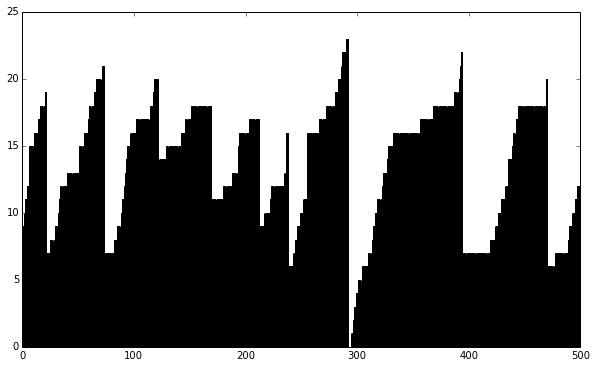

In [40]:
plt.bar(range(0,500),arrival_hour[0:500]);

Next, get weekday.

In [41]:
arrival_weekday = map(lambda s: datetime.datetime.strptime(s['startTime'][0:19], "%Y-%m-%dT%H:%M:%S").weekday(),j)
arrival_weekday[0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

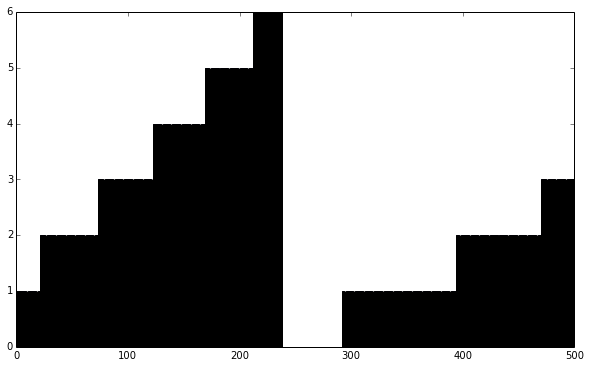

In [42]:
plt.bar(range(0,500),arrival_weekday[0:500]);

Create a new feature matrix by taking a step back, and zipping the time feature vectors with original list of current POIs, i.e. labels.

In [43]:
features = zip(labels, arrival_hour, arrival_weekday)
features[0:10]

[(1, 9, 1),
 (1, 10, 1),
 (1, 11, 1),
 (1, 11, 1),
 (1, 12, 1),
 (1, 12, 1),
 (1, 15, 1),
 (1, 15, 1),
 (-1, 15, 1),
 (-1, 15, 1)]

Then repeat the steps above, but using the new feature matrix instead of only currentPOI. We are still trying to predict next POI.

In [44]:
pois = filter(lambda x: x[0] > -1,features)
sequence=[pois[0]]
for i in range(len(pois)):
    if (pois[i][0]!=sequence[-1][0]):
        sequence.append(pois[i])

In [45]:
currentPOI = np.vstack(sequence[0:(len(sequence)-1)])
nextPOI = np.array(map(lambda x: x[2], sequence)[1:(len(sequence))])
zip(currentPOI, nextPOI)[0:20]

[(array([1, 9, 1]), 1),
 (array([ 2, 16,  1]), 1),
 (array([ 0, 18,  1]), 2),
 (array([2, 7, 2]), 2),
 (array([1, 8, 2]), 2),
 (array([ 0, 21,  2]), 3),
 (array([1, 7, 3]), 3),
 (array([ 0, 17,  3]), 3),
 (array([ 2, 18,  3]), 3),
 (array([ 0, 20,  3]), 5),
 (array([ 5, 17,  5]), 5),
 (array([ 0, 17,  5]), 6),
 (array([2, 9, 6]), 6),
 (array([ 5, 12,  6]), 6),
 (array([ 0, 12,  6]), 0),
 (array([1, 7, 0]), 0),
 (array([ 2, 16,  0]), 0),
 (array([ 6, 16,  0]), 0),
 (array([ 0, 18,  0]), 1),
 (array([1, 7, 1]), 1)]

In [46]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(currentPOI, nextPOI)
clf.score(currentPOI, nextPOI)

0.93289689034369883

In [47]:
clf = svm.SVC()
clf.fit(currentPOI, nextPOI)
clf.score(currentPOI, nextPOI)

0.91816693944353522

The scores on the training sets look really good now, which means that the features we added contributed significantly. However, there is always the risk of over-fitting: Since we only have one trace in the test set, the models may have learned the specifics of this trace, and does not generalize to unseen data.

Let try it on unseen data too.

In [48]:
X_train = currentPOI[0:split]
X_test = currentPOI[split:currentPOI.shape[0]]
y_train = nextPOI[0:split]
y_test = nextPOI[split:len(nextPOI)]

In [49]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.86413043478260865

In [50]:
clf = svm.SVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.80434782608695654

Nice! As we can see, the performance on the unseen test set was not as good as on the training set, but this is expected. However, the scores on the test set are still pretty good.

## Next steps and conclusion

Before anything else, the next step would be to perform an error analysis: Look specifically at the cases where the prediction fails. Can we see anything in common in the failed predictions that will help us improve?

There are a couple of other features that could improve prediction performance further: Two previous POIs, leave time, staying time, frequency, recency etc. Also, we noticed that arrival time and day of week contributed a lot. However, it is also likely that arrival time and current POI are highly correlated.

As you may have noticed in the data, each point is not sampled at a regular frequency. Some points have a long time between start and end time, and the staying time is probably important. This should be taken into account when performing the clustering. I leave it to the reader as an exercise to make this extension.

You may also want to change the representation of time. Currently, arrival hour is a ratio level data, but is also cyclical, since 0 comes after 23. If we want to use the information we have in that the time data is ordered, rather than just look at the values as unordered categories, we may want to choose a different representation that can be used by the ML models. One such representation is to split each time feature into two, taking cosine and sine of the time value.

Human mobility and predictability of human movements has become a research area in itself. If you are interested, please have a look at this paper:

Gonzalez, M. C., Hidalgo, C. A., & Barabasi, A. L. (2008). Understanding individual human mobility patterns. Nature, 453(7196), 779-782. 

PDF is available here: http://arxiv.org/pdf/0806.1256.pdf

Finally, I would really like to have feedback on this piece. Please post comments on the Sony Developer World blog post: http://developer.sonymobile.com/2015/07/28/app-developers-can-now-explore-lifelog-user-predictability-with-data-science-and-machine-learning/